# Creación de la clase para realizar las transformaciones


## Traslación de imágenes

Para el caso de las traslaciones, como se vio en clase, si tenemos un vector $(x,y)$ las coordenadas trasladadas por un vector $(t_{x},t_{y})$ quedarían de la siguiente manera:

\begin{align*}
x' = t_{x} + x\\
y' = t_{y} + y 
\end{align*}

En lo que consistirá la traslación entonces es en hacer la asignación:

$$f'(x+t_{x},y+t_{y}) = f(x,y)$$

Donde $f'(x,y)$ sería la imágen trasladada y $f(x,y)$ es la imagen original. 


## Rotación de imágenes

Para la rotación de imágenes usaremos la siguiente matriz de transformación:

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix} = 
\begin{pmatrix}
\cos{\theta}& \sin{\theta}\\
-\sin{\theta} & \cos{\theta}
\end{pmatrix} \begin{pmatrix}
x\\
y
\end{pmatrix} = \begin{pmatrix}
x\cos{\theta} +y\sin{\theta} \\
-x\sin{\theta} +y\cos{\theta}
\end{pmatrix}
\end{equation}

Realmente aquí el detalle va a estar en como hacer el padding para la rotación, nos podemos ayudar de la siguiente figura:

<img src="rotated_rectangle.png" width="400" height="400">

Vemos que tendriamos que construir una imágen de ancho:

\begin{equation}
\text{ancho} = n\sin{\theta} + m\cos{\theta}
\end{equation}

y de altura:

\begin{equation}
\text{altura} = m \sin{\theta} + n\cos{\theta}
\end{equation}

Entonces podemos proponer que la asignación de valores se haga de la siguiente forma:

\begin{equation}
f'(x\cos{\theta} +y\sin{\theta},-x\sin{\theta} +y\cos{\theta}) = f(x,y)
\end{equation}

Sin embargo esto no sería del todo correcto porque de la imagen presentada vemos que tenemos una traslación en el eje y de $(0,m\sin{\theta})$

De modo que la asignación correcta sería

\begin{equation}
f'(x\cos{\theta} +y\sin{\theta},m\sin{\theta}-x\sin{\theta} +y\cos{\theta}) = f(x,y)
\end{equation}

Uno de los problemas con el que nos podriamos encontrar al hacer esto es que se debe realizar un redondeo de la posición en donde se asignaran los puntos rotados. Dado que el coseno y el seno son funciones no lineales no podemos asegurar que la asignación sea punto a punto, es decir podría suceder que mas de un punto se asigne a una posición o que haya puntos que deberian ser llenados que permanezcan en negro, en pocas palabras podriamos tener un problema de aliasing. 

Lo que se podría hacer es realizar lo que sería un proceso un tanto inverso, donde obtengamos x,y a partir de los puntos de la imagen rotada, en esta forma nos aseguramos de llenar todos los puntos de la imagen, usaremos la matrix inversa de la que se presento, que sería simplemente su transpuesta, ya que se trata de una matrix ortogonal. 


\begin{equation}
\begin{pmatrix}
x \\
y
\end{pmatrix} = 
\begin{pmatrix}
\cos{\theta}& -\sin{\theta}\\
\sin{\theta} & \cos{\theta}
\end{pmatrix} \begin{pmatrix}
x'\\
y'
\end{pmatrix} = \begin{pmatrix}
x'\cos{\theta} -y'\sin{\theta} \\
x'\sin{\theta}+y'\cos{\theta}
\end{pmatrix}
\end{equation}

La asignación considerando la tralación en $y$ de $(0,m\sin{\theta})$ que ya se mencionó sería:

\begin{equation}
f'(x',y') =f(x'\cos{\theta} -(y'-m\sin{\theta})\sin{\theta},x'\sin{\theta} +(y'-m\sin{\theta})\cos{\theta} ) 
\end{equation}

A este método sencillo de tomar la inversa se le conoce como interpolación de vecino mas cercano. 

In [66]:
#Define the class that will do the transformations
import cv2
from matplotlib import pyplot as plt
import numpy as np
class ImageTransformator:
    #This receives coordinates for the new origin
    def imageTranslate(self,img,tx,ty):
        #Round tx and ty
        tx = np.round(tx)
        ty = np.round(ty)
        n = img.shape[0]
        m = img.shape[1]
        #Create a nuew matrix with same dimensions
        translatedImg = np.zeros((n+ty,m+tx))
        for i in range(0,n-1):
            for j in range(0,m-1):
                translatedImg[i+ty,j+tx] = img[i,j]
        return translatedImg
    
    def imageAliasingRotate(self,img, angle):
        angleRad = angle*np.pi/180
        n = img.shape[0]
        m = img.shape[1]
        
        imWidth = int(n*np.sin(angleRad) + m*np.cos(angleRad))
        imHeight = int(m*np.sin(angleRad) + n*np.cos(angleRad))
        
        rotatedImg = np.zeros((imHeight,imWidth))
        for i in range(0,n-1):
            for j in range(0,m-1):
                rowPos = m*np.sin(angleRad)-j*np.sin(angleRad)+i* np.cos(angleRad)
                colPos = j*np.cos(angleRad) +i*np.sin(angleRad)
                row = int(np.floor(rowPos))
                col = int(np.floor(colPos))
                rotatedImg[row,col] = img[i,j]
        return rotatedImg
    
    #Para eliminar el aliasing habrá que hacer una versión de la rotación usando 
    #Interpolación 
    def imageRotate(self, img, angle):
        if(angle <= 90 and angle >0):
            angleRad = angle*np.pi/180
            n = img.shape[0]
            m = img.shape[1]
            imWidth = int(n*np.sin(angleRad) +m*np.cos(angleRad))
            imHeight = int(m*np.sin(angleRad) +n*np.cos(angleRad))
            rotatedImg = np.zeros((imHeight,imWidth))
        
            for s in range(0,imHeight):
                for t in range(0, imWidth):
                    rowPos = t*np.sin(angleRad) +(s-m*np.sin(angleRad))*np.cos(angleRad)
                    colPos = t*np.cos(angleRad) -(s-m*np.sin(angleRad))*np.sin(angleRad)
                
                    i = int(rowPos)
                    j = int(colPos)
                
                    if(i >=0  and i < n and j >= 0 and j < m ):
                        rotatedImg[s,t] = img[i,j]
        else:
            num90Rotations = int(angle/90)
            res = angle%90
            for i in range(0,num90Rotations):
                img = self.imageRotate(img,90)
            rotatedImg = self.imageRotate(img,res)
        return rotatedImg
            
            
        
        
        
    
    
                
        
        

## Pruebas traslación

In [2]:
#Abrimos la imagen
img = cv2.imread('im.jpg',0)

Text(0.5, 1.0, 'Imágen trasladada')

<Figure size 432x288 with 0 Axes>

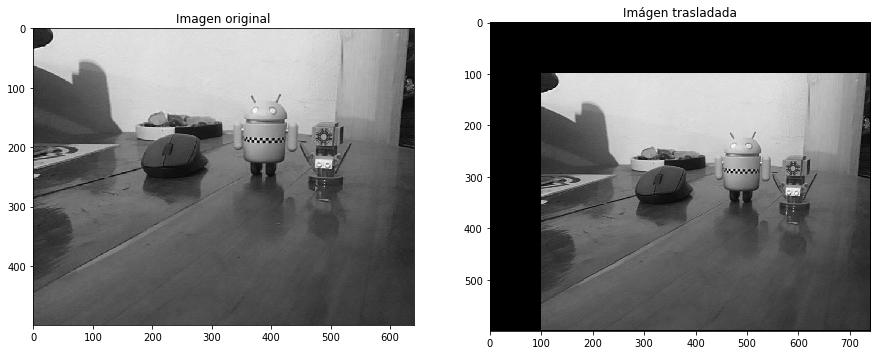

In [3]:
#Hacemos la traslación
transformator = ImageTransformator()
translatedImg = transformator.imageTranslate(img,100,100)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 10))
#La imagen original 
ax[0].imshow(img,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(translatedImg,cmap = 'gray')
ax[1].set_title('Imágen trasladada')



## Rotación de imágenes pruebas

### Primer versión (aliasing)

Text(0.5, 1.0, 'Imágen rotada con aliasing')

<Figure size 432x288 with 0 Axes>

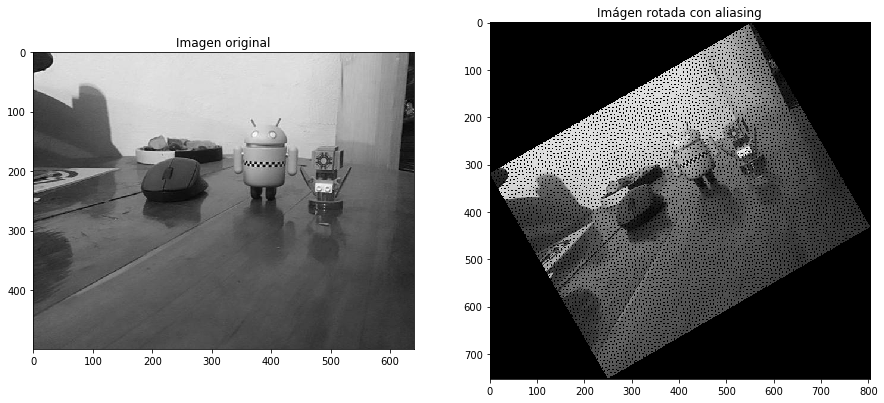

In [4]:
transformator = ImageTransformator()
rotatedImg = transformator.imageAliasingRotate(img,30)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 10))
#La imagen original 
ax[0].imshow(img,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(rotatedImg,cmap = 'gray')
ax[1].set_title('Imágen rotada con aliasing')


### Segunda versión con interpolación del vecino mas cercano

Text(0.5, 1.0, 'Imagen rotada')

<Figure size 432x288 with 0 Axes>

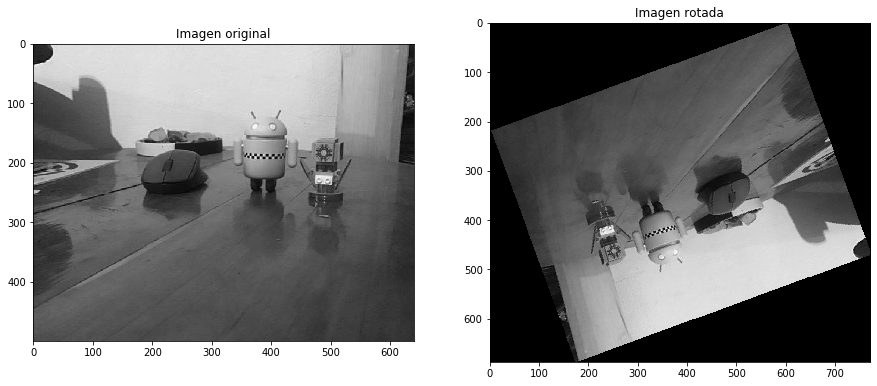

In [68]:
transformator = ImageTransformator()
rotatedImg = transformator.imageRotate(img,200)
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(15, 110))
#La imagen original 
ax[0].imshow(img,cmap = 'gray')
ax[0].set_title('Imagen original')
ax[1].imshow(rotatedImg,cmap = 'gray')
ax[1].set_title('Imagen rotada')